In [ ]:
import torch, utils
from torch.utils.data import DataLoader
from datasets import MIMII

mimii_dataset_SNR = 6
N, K, query_size = 8, 5, 1
num_trains = 10
args = utils.Args(seed=42, N=N, K=K, query_size=query_size, SNR=mimii_dataset_SNR, dataset_name='mimii', in_data_type='audio')
utils.global_manual_seed(seed=args.seed, device=args.device)

#加载数据集
mimii_trainset = MIMII(root_dir=f'./data/mimii/{mimii_dataset_SNR}'+'dB_SNR',
                                machine_classes=['fan', 'pump', 'valve', 'slider'],
                                model_ids=['id_00'], categories=['abnormal', 'normal'],
                                N=N, K=K, query_size=query_size, seed=args.seed,
                                num_trainsets=num_trains, is_train=True)
mimii_testset = MIMII(root_dir=f'./data/mimii/{mimii_dataset_SNR}'+'dB_SNR',
                                machine_classes=['fan', 'pump', 'valve', 'slider'],
                                model_ids=['id_00'], categories=['abnormal', 'normal'],
                                N=N, K=K, query_size=query_size, seed=args.seed,
                                num_trainsets=num_trains, is_train=False)

train_loader = DataLoader(mimii_trainset, batch_size=1, num_workers=args.num_workers, pin_memory=args.pin_memory)
test_loader = DataLoader(mimii_testset, batch_size=1, num_workers=args.num_workers, pin_memory=args.pin_memory)
print(f"训练数据集大小:{len(mimii_trainset)}\n测试数据集大小:{len(mimii_testset)}")

训练数据集大小:10
测试数据集大小:168


In [2]:
import nets

cnn1d_num_hidden_channels = 64
cnn2d_num_hidden_channels = 32
num_cnn1d_out_features = cnn1d_num_hidden_channels*2
num_cnn2d_out_features = cnn2d_num_hidden_channels*2
cnn1d_embed_size = 256
cnn2d_embed_size = 192
final_embed_size = 192
cross_class_conv1d_kernel_size = 4
cross_class_conv1d_stride = 4
gat_num_heads = 1
dropout_rate = 0.5

cnn1d = nets.AudioCNN1D(num_channels_input=8, 
                        num_channels_hidden=cnn1d_num_hidden_channels)
cnn2d = nets.AudioCNN2D(num_channels_input=8,
                        num_channels_hidden=cnn2d_num_hidden_channels)    

ensemble_gcn = nets.EnsembleGCN(num_feature_inputs=(num_cnn1d_out_features, 
                                                    num_cnn2d_out_features),
                                feature_embed_sizes=(cnn1d_embed_size,
                                                     cnn2d_embed_size),
                                final_embed_size=final_embed_size,
                                cross_class_conv1d_kernel_size=cross_class_conv1d_kernel_size,
                                cross_class_conv1d_stride=cross_class_conv1d_stride,
                                dropout_rate=dropout_rate,
                                num_classes_output=args.N, query_size=query_size,
                                gat_num_heads=gat_num_heads)

ensemble_net = nets.EnsembleNet(cnn1d=cnn1d,
                                cnn2d=cnn2d,
                                ensemble_gcn=ensemble_gcn,
                                in_data_type='audio',
                                dropout_rate=dropout_rate)

Epoch:  1 | Loss: 0.3607390 | Query Acc: 50.00%
Epoch:  2 | Loss: 0.1653540 | Query Acc: 86.25%
Epoch:  3 | Loss: 0.0704187 | Query Acc: 93.75%
Epoch:  4 | Loss: 0.0571234 | Query Acc: 91.25%
Epoch:  5 | Loss: 0.0274538 | Query Acc: 100.00%
Epoch:  6 | Loss: 0.0234712 | Query Acc: 97.50%
Epoch:  7 | Loss: 0.0162550 | Query Acc: 98.75%
Epoch:  8 | Loss: 0.0116895 | Query Acc: 100.00%
Epoch:  9 | Loss: 0.0076142 | Query Acc: 100.00%
Epoch: 10 | Loss: 0.0074994 | Query Acc: 98.75%
Epoch: 11 | Loss: 0.0056477 | Query Acc: 100.00%
Epoch: 12 | Loss: 0.0051933 | Query Acc: 100.00%
Epoch: 13 | Loss: 0.0062535 | Query Acc: 100.00%
Epoch: 14 | Loss: 0.0041864 | Query Acc: 100.00%
Epoch: 15 | Loss: 0.0043662 | Query Acc: 100.00%
Epoch: 16 | Loss: 0.0048783 | Query Acc: 100.00%
Epoch: 17 | Loss: 0.0045463 | Query Acc: 100.00%
Epoch: 18 | Loss: 0.0065056 | Query Acc: 98.75%
Epoch: 19 | Loss: 0.0043361 | Query Acc: 100.00%
Epoch: 20 | Loss: 0.0045036 | Query Acc: 100.00%
Epoch: 21 | Loss: 0.0059738 

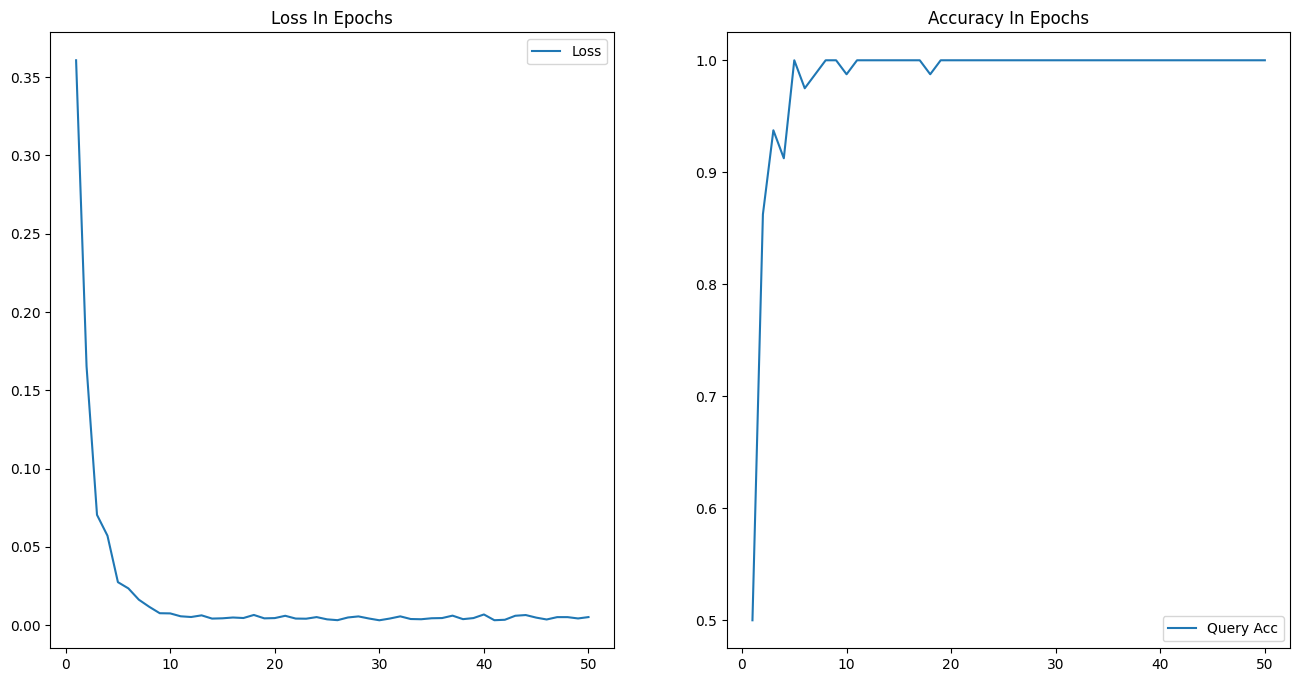

In [ ]:
from train_test import train, test

train(ensemble_net, train_loader, args=args,
            num_epochs=50, lr=0.002, weight_decay=0.,
            scheduler_stepsz=10, scheduler_gamma=0.8) 

Test Batch   1   |   Query Acc:100.00%
Test Batch   2   |   Query Acc:100.00%
Test Batch   3   |   Query Acc:100.00%
Test Batch   4   |   Query Acc:100.00%
Test Batch   5   |   Query Acc:100.00%
Test Batch   6   |   Query Acc:100.00%
Test Batch   7   |   Query Acc:100.00%
Test Batch   8   |   Query Acc:100.00%
Test Batch   9   |   Query Acc:100.00%
Test Batch  10   |   Query Acc:100.00%
Test Batch  11   |   Query Acc:100.00%
Test Batch  12   |   Query Acc:100.00%
Test Batch  13   |   Query Acc:100.00%
Test Batch  14   |   Query Acc:100.00%
Test Batch  15   |   Query Acc:100.00%
Test Batch  16   |   Query Acc:100.00%
Test Batch  17   |   Query Acc:100.00%
Test Batch  18   |   Query Acc:100.00%
Test Batch  19   |   Query Acc:100.00%
Test Batch  20   |   Query Acc:100.00%
Test Batch  21   |   Query Acc:100.00%
Test Batch  22   |   Query Acc:100.00%
Test Batch  23   |   Query Acc:100.00%
Test Batch  24   |   Query Acc:100.00%
Test Batch  25   |   Query Acc:100.00%
Test Batch  26   |   Quer

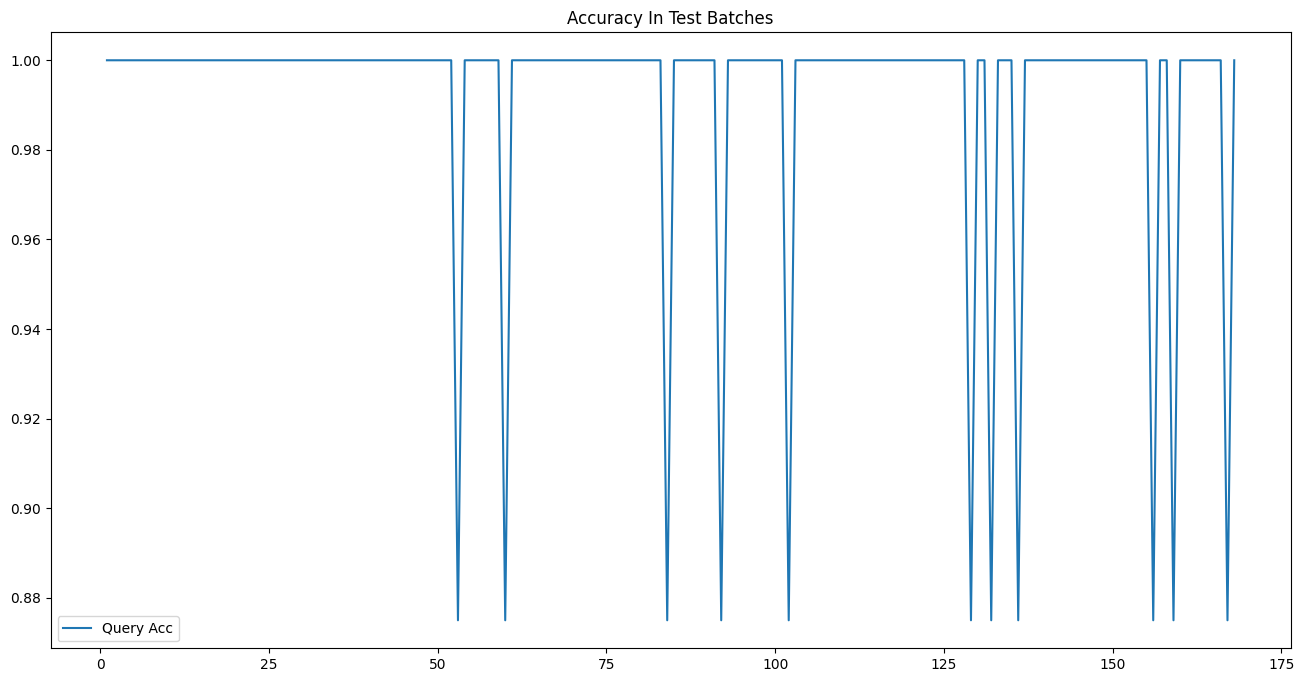

In [4]:
avg_test_acc = test(ensemble_net, test_loader, args)